<hr>

# Step Size Distribution Analysis
author, date = p.caldas@fct.unl.pt, May 2021 Version

<hr>

### All Functions to Compute Step Size Distribution - might need some revision

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rayleigh, gamma
from src.track_filter import FilterTracks

def StepSizeDist(traj, lag = 1, coord = ['POSITION_X','POSITION_Y']):
        ''' computes step size distribution for a given lag time (step)'''
        
        traj_lagged = traj[::lag]
        
        steps = []

        for frame in range(1, len(traj_lagged)):
            step_dist = np.linalg.norm(traj_lagged[coord].iloc[frame] - (traj_lagged[coord].iloc[frame-1]))
            
            steps.append(step_dist)

        return steps   
    
def ComputeStepSizeDistribution(traj_table, lag = 1, min_disp = 10,  clip = -1, coord = ['POSITION_X','POSITION_Y']):
    ''' computes step size distribution for all trajecotries (traj_table) for a given lag time (step)
    min_disp: filter tracks shorter than this value (in frames)
    clip: truncate number of tracks to analyze; default = -1 analyze all tracks'''
    
    traj_table = FilterTracks(traj_table, min_disp)
    traj_table = Truncate(traj_table, clip)
    
    all_steps = UnpackList(traj_table[:clip].groupby('TRACK_ID').apply(StepSizeDist, lag = lag, coord = coord))
    
    return all_steps

def PlotMultipleStepSizes(traj_table, color = plt.cm.viridis, min_disp = 10,  clip = -1, coord = ['POSITION_X','POSITION_Y']):
    
    all_lag_steps = []
    
    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)

    for lag in np.arange(1, 12, 2):
        
        sample_steps = ComputeStepSizeDistribution(traj_table, lag = lag, min_disp = min_disp, clip = clip, coord = coord)
        
        sns.kdeplot(sample_steps, ax = ax, color = color(lag * 10), label = 'lag =' + str(lag))
        
        # plt.hist(sample_steps, lw = 1.2, color = plt.cm.viridis_r(lag * 20), edgecolor = 'w', 
        #         density = True, alpha = 0.4, label = 'lag =' + str(lag))
        
        ax.set_xlabel('stepsize'); ax.set_ylabel('PDF')
        ax.legend(fontsize = 8, frameon = False)
        
        # unecessary fancy stuff
        ax.tick_params(direction = 'inout')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        all_lag_steps.append(sample_steps)
        
    return all_lag_steps


def GammaFit(array, loc = 0.2, scale = 0.2, d = 'pdf'):
    
    gamma_param = gamma.fit(array, loc = loc, scale = scale)
    
    counts, bins = np.histogram(array, density = True)
    bins_center = (bins[:-1] + np.diff(bins) / 2) #calculate bin center to use as y data to fit
    
    x_axis = np.linspace(0, bins[-1], 200)
    
    gamma_fit = gamma.pdf(x_axis, *gamma_param)
    
    if d == 'cdf': # show a cumulative probability instead
        gamma_fit = gamma.cdf(x_axis, *gamma_param)
    
    return x_axis, gamma_fit, gamma.mean(*gamma_param)

def FitGammaFunctionToSteps(all_lag_steps, color = plt.cm.viridis, loc = 0, scale = 0.2):
    
    all_means = []
    lags = np.arange(1, 12, 2)
    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)
    
    for dist, lag in zip(all_lag_steps, lags): #double check if using the same lags!!!
        
        x_axis, gamma_fit, gamma_mean = GammaFit(dist, loc = loc, scale = scale)
        plt.plot(x_axis, gamma_fit, color = color(lag * 10), lw = 1.5, label = 'lag =' + str(lag))
        
        all_means.append(gamma_mean)
        
        ax.set_xlabel('stepsize'); ax.set_ylabel('PDF')
        plt.legend(fontsize = 8, frameon = False)
        
        # unecessary fancy stuff
        ax.tick_params(direction = 'inout')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        #ax.set_xlim([0,2])
    
    return all_means, lags

def read_trackmate_xml_tracks(xml_file):
    """Reads tracks from trackmate xml track file and converts into a user-friendly DataFrame """
    
    from xml.etree import cElementTree as ET
    
    tracks = ET.parse(xml_file)
    frame_interval = float(tracks.getroot().attrib["frameInterval"])
    n_tracks = float(tracks.getroot().attrib["nTracks"])
    
    attributes = []
    for ti, track in enumerate(tracks.iterfind('particle')):
        for spots in track.iterfind('detection'):
            attributes.append([ti, int(spots.attrib.get('t')),
                                   float(spots.attrib.get('x')),
                                   float(spots.attrib.get('y'))])

    track_table = pd.DataFrame(attributes, columns=['TRACK_ID','FRAME','POSITION_X','POSITION_Y'])
    
    print('total tracks: {}'.format(track_table.TRACK_ID.unique().max()))
    
    return track_table, frame_interval, n_tracks

def Truncate(table, tracks = -1):
    ''' reduce number of tracks to analyze to save computer power'''   
    
    # truncate number of tracks to analyze; default is -1 to analyze eveything
    if tracks == -1: table = table

    else:
        trunc = table[table['TRACK_ID'] == tracks].index[-1]
        table = table.iloc[:trunc]
    
    return table    

def UnpackList(list):
    return [i for j in list for i in j]

### Compute Step Size Distribuition of All Tracks

In [73]:
file = 'data/FtsA R286W_Exp4_114ms_p3.xml'
tracks, rate, n = read_trackmate_xml_tracks(file)

total tracks: 2798


#### raw step size distribution of all tracks

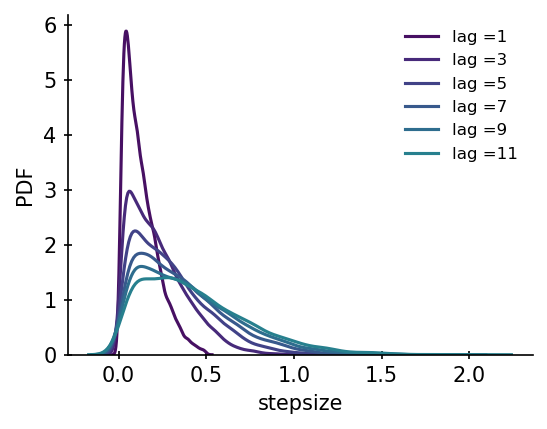

In [81]:
all_steps = PlotMultipleStepSizes(tracks, min_disp = 30, clip = -1)

#### smooth curves above with a gamma fitting

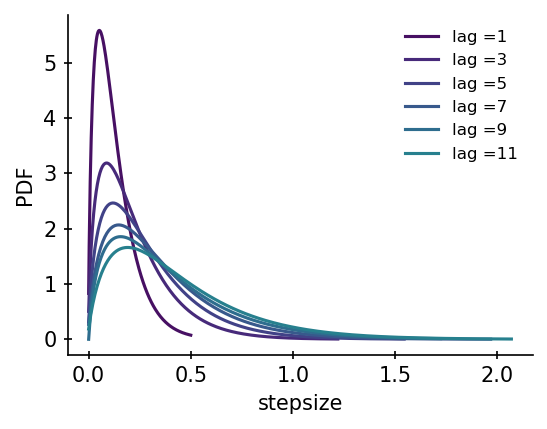

In [85]:
peaks, lags = FitGammaFunctionToSteps(all_steps)

### ... and might be informative to plot the peaks as a function of the lag time

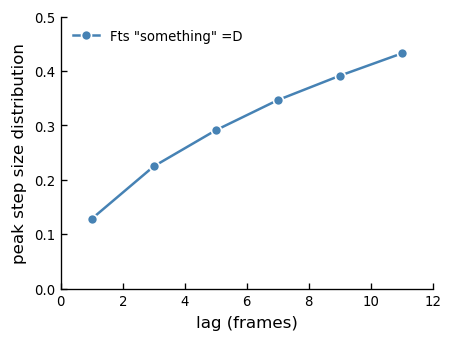

In [106]:
fig, ax = plt.subplots(figsize = (4,3), dpi = 120)

plt.plot(lags, peaks, '-o', color = 'steelblue', markeredgecolor = 'w', label = 'Fts "something" =D')

ax.set_xlabel('lag (frames)'); ax.set_ylabel('peak step size distribution')
ax.tick_params(direction = 'in', top=False, right = False, labelsize = 8)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_xlim([0,12]); ax.set_ylim([0,0.5])
plt.legend(fontsize = 8, frameon = False, loc = 2);